In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/converted.zip
!unzip -q dataset/test9classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConv(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnection = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnection = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnection:
            skip = self.skipConnection(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        #self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.conv3 = SeparableConv(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        #x = self.block5(x)
        #x = self.block6(x)
        #x = self.block7(x)
        #x = self.block8(x)
        #x = self.block9(x)
        #x = self.block10(x)
        #x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
with open('test9classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']
4050
4050


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 5 #
batch_size_val = 5

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('converted/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test9classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: STR


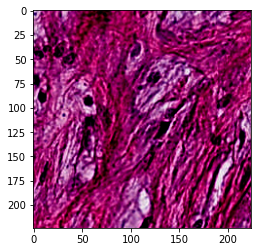

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=9).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("Xception+9SGD.pth"):
        os.remove("Xception+9SGD.pth")
      torch.save(model.state_dict(), 'Xception+9SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=9).to(device)
  model.load_state_dict(torch.load('Xception+9SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-5-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8823

Test: Average loss: 0.5099, Accuracy: 4359/5400 (80.72%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5274

Test: Average loss: 0.3518, Accuracy: 4734/5400 (87.67%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4170

Test: Average loss: 0.2147, Accuracy: 5037/5400 (93.28%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3328

Test: Average loss: 0.3826, Accuracy: 4708/5400 (87.19%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2876

Test: Average loss: 0.1959, Accuracy: 5069/5400 (93.87%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2604

Test: Average loss: 0.1878, Accuracy: 5034/5400 (93.22%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2314

Test: Average loss: 0.1688, Accuracy: 5070/5400 (93.89%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1992

Test: Average loss: 0.1291, Accuracy: 5158/5400 (95.52%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1908

Test: Average loss: 0.2302, Accuracy: 4975/5400 (92.13%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1667

Test: Average loss: 0.1267, Accuracy: 5173/5400 (95.80%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1486

Test: Average loss: 0.1704, Accuracy: 5026/5400 (93.07%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1502

Test: Average loss: 0.1191, Accuracy: 5164/5400 (95.63%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1294

Test: Average loss: 0.1279, Accuracy: 5172/5400 (95.78%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1176

Test: Average loss: 0.1246, Accuracy: 5192/5400 (96.15%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1106

Test: Average loss: 0.1152, Accuracy: 5189/5400 (96.09%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1119

Test: Average loss: 0.1103, Accuracy: 5204/5400 (96.37%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0998

Test: Average loss: 0.1373, Accuracy: 5137/5400 (95.13%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0928

Test: Average loss: 0.1053, Accuracy: 5211/5400 (96.50%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0871

Test: Average loss: 0.0677, Accuracy: 5292/5400 (98.00%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0743

Test: Average loss: 0.0853, Accuracy: 5256/5400 (97.33%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0832

Test: Average loss: 0.0799, Accuracy: 5255/5400 (97.31%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0773

Test: Average loss: 0.0665, Accuracy: 5278/5400 (97.74%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0632

Test: Average loss: 0.1012, Accuracy: 5232/5400 (96.89%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0666

Test: Average loss: 0.0689, Accuracy: 5284/5400 (97.85%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0595

Test: Average loss: 0.1114, Accuracy: 5209/5400 (96.46%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0612

Test: Average loss: 0.0751, Accuracy: 5280/5400 (97.78%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0578

Test: Average loss: 0.0636, Accuracy: 5292/5400 (98.00%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0506

Test: Average loss: 0.0820, Accuracy: 5247/5400 (97.17%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0456

Test: Average loss: 0.0907, Accuracy: 5241/5400 (97.06%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.0722, Accuracy: 5285/5400 (97.87%)

Test: Average loss: 0.0710, Accuracy: 3965/4050 (97.90%)

Experiment:  2
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8659

Test: Average loss: 0.4870, Accuracy: 4511/5400 (83.54%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5362

Test: Average loss: 0.4068, Accuracy: 4649/5400 (86.09%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4108

Test: Average loss: 0.4344, Accuracy: 4600/5400 (85.19%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3330

Test: Average loss: 0.2920, Accuracy: 4853/5400 (89.87%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2896

Test: Average loss: 0.1831, Accuracy: 5071/5400 (93.91%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2445

Test: Average loss: 0.1739, Accuracy: 5097/5400 (94.39%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2241

Test: Average loss: 0.1657, Accuracy: 5125/5400 (94.91%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1948

Test: Average loss: 0.1490, Accuracy: 5142/5400 (95.22%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1822

Test: Average loss: 0.1363, Accuracy: 5151/5400 (95.39%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1618

Test: Average loss: 0.1854, Accuracy: 5046/5400 (93.44%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1564

Test: Average loss: 0.4155, Accuracy: 4756/5400 (88.07%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1276

Test: Average loss: 0.1349, Accuracy: 5148/5400 (95.33%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1242

Test: Average loss: 0.1057, Accuracy: 5206/5400 (96.41%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1158

Test: Average loss: 0.1032, Accuracy: 5232/5400 (96.89%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1096

Test: Average loss: 0.0923, Accuracy: 5241/5400 (97.06%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1030

Test: Average loss: 0.0937, Accuracy: 5225/5400 (96.76%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0924

Test: Average loss: 0.1000, Accuracy: 5224/5400 (96.74%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0845

Test: Average loss: 0.0924, Accuracy: 5255/5400 (97.31%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0838

Test: Average loss: 0.0819, Accuracy: 5262/5400 (97.44%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0694

Test: Average loss: 0.0771, Accuracy: 5275/5400 (97.69%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0637

Test: Average loss: 0.0847, Accuracy: 5263/5400 (97.46%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0576

Test: Average loss: 0.0867, Accuracy: 5248/5400 (97.19%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0618

Test: Average loss: 0.0972, Accuracy: 5248/5400 (97.19%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0588

Test: Average loss: 0.1061, Accuracy: 5218/5400 (96.63%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0528

Test: Average loss: 0.5009, Accuracy: 4637/5400 (85.87%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0562

Test: Average loss: 0.0823, Accuracy: 5257/5400 (97.35%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0409

Test: Average loss: 0.0735, Accuracy: 5269/5400 (97.57%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0498

Test: Average loss: 0.0827, Accuracy: 5291/5400 (97.98%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0481

Test: Average loss: 0.0531, Accuracy: 5312/5400 (98.37%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0410

Test: Average loss: 0.0776, Accuracy: 5272/5400 (97.63%)

Test: Average loss: 0.0575, Accuracy: 3982/4050 (98.32%)

Experiment:  3
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8760

Test: Average loss: 0.6156, Accuracy: 4261/5400 (78.91%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5361

Test: Average loss: 0.4311, Accuracy: 4568/5400 (84.59%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4009

Test: Average loss: 0.2863, Accuracy: 4917/5400 (91.06%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3364

Test: Average loss: 0.1963, Accuracy: 5083/5400 (94.13%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2814

Test: Average loss: 0.2048, Accuracy: 5035/5400 (93.24%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2382

Test: Average loss: 0.2358, Accuracy: 4992/5400 (92.44%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2218

Test: Average loss: 0.1854, Accuracy: 5056/5400 (93.63%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1914

Test: Average loss: 0.1342, Accuracy: 5161/5400 (95.57%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1787

Test: Average loss: 0.1531, Accuracy: 5118/5400 (94.78%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1543

Test: Average loss: 0.1588, Accuracy: 5113/5400 (94.69%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1447

Test: Average loss: 0.1302, Accuracy: 5182/5400 (95.96%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1310

Test: Average loss: 0.1701, Accuracy: 5107/5400 (94.57%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1230

Test: Average loss: 0.1324, Accuracy: 5164/5400 (95.63%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1192

Test: Average loss: 0.1030, Accuracy: 5202/5400 (96.33%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1033

Test: Average loss: 0.1040, Accuracy: 5215/5400 (96.57%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0953

Test: Average loss: 0.1408, Accuracy: 5166/5400 (95.67%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0905

Test: Average loss: 0.0922, Accuracy: 5233/5400 (96.91%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0885

Test: Average loss: 0.0919, Accuracy: 5244/5400 (97.11%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0882

Test: Average loss: 0.1283, Accuracy: 5187/5400 (96.06%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0736

Test: Average loss: 0.1662, Accuracy: 5126/5400 (94.93%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0759

Test: Average loss: 0.0941, Accuracy: 5233/5400 (96.91%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0676

Test: Average loss: 0.0682, Accuracy: 5267/5400 (97.54%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0615

Test: Average loss: 0.0895, Accuracy: 5266/5400 (97.52%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0563

Test: Average loss: 0.0843, Accuracy: 5247/5400 (97.17%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0476

Test: Average loss: 0.0822, Accuracy: 5288/5400 (97.93%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0545

Test: Average loss: 0.0607, Accuracy: 5287/5400 (97.91%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0544

Test: Average loss: 0.0790, Accuracy: 5265/5400 (97.50%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0540

Test: Average loss: 0.0797, Accuracy: 5277/5400 (97.72%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0395

Test: Average loss: 0.0750, Accuracy: 5285/5400 (97.87%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0371

Test: Average loss: 0.0899, Accuracy: 5250/5400 (97.22%)

Test: Average loss: 0.0758, Accuracy: 3968/4050 (97.98%)

Experiment:  4
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8855

Test: Average loss: 0.5785, Accuracy: 4292/5400 (79.48%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5413

Test: Average loss: 0.4424, Accuracy: 4569/5400 (84.61%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3987

Test: Average loss: 0.4026, Accuracy: 4704/5400 (87.11%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3238

Test: Average loss: 0.2936, Accuracy: 4889/5400 (90.54%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2764

Test: Average loss: 0.2992, Accuracy: 4869/5400 (90.17%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2369

Test: Average loss: 0.1691, Accuracy: 5101/5400 (94.46%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2098

Test: Average loss: 0.1485, Accuracy: 5139/5400 (95.17%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1848

Test: Average loss: 0.1943, Accuracy: 5040/5400 (93.33%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1759

Test: Average loss: 0.1195, Accuracy: 5212/5400 (96.52%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1523

Test: Average loss: 0.1574, Accuracy: 5142/5400 (95.22%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1421

Test: Average loss: 0.1381, Accuracy: 5187/5400 (96.06%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1299

Test: Average loss: 0.0986, Accuracy: 5233/5400 (96.91%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1173

Test: Average loss: 0.0900, Accuracy: 5255/5400 (97.31%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0998

Test: Average loss: 0.1604, Accuracy: 5129/5400 (94.98%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1085

Test: Average loss: 0.1159, Accuracy: 5199/5400 (96.28%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0953

Test: Average loss: 0.1260, Accuracy: 5195/5400 (96.20%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0967

Test: Average loss: 0.1406, Accuracy: 5147/5400 (95.31%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0827

Test: Average loss: 0.1392, Accuracy: 5150/5400 (95.37%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0741

Test: Average loss: 0.0909, Accuracy: 5233/5400 (96.91%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0626

Test: Average loss: 0.1030, Accuracy: 5206/5400 (96.41%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0546

Test: Average loss: 0.0948, Accuracy: 5250/5400 (97.22%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0759

Test: Average loss: 0.0683, Accuracy: 5278/5400 (97.74%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0542

Test: Average loss: 0.0760, Accuracy: 5283/5400 (97.83%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0495

Test: Average loss: 0.0852, Accuracy: 5272/5400 (97.63%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0627

Test: Average loss: 0.0862, Accuracy: 5264/5400 (97.48%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0477

Test: Average loss: 0.0788, Accuracy: 5270/5400 (97.59%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0436

Test: Average loss: 0.0714, Accuracy: 5272/5400 (97.63%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0400

Test: Average loss: 0.0717, Accuracy: 5290/5400 (97.96%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0501

Test: Average loss: 0.1023, Accuracy: 5229/5400 (96.83%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0394

Test: Average loss: 0.0697, Accuracy: 5286/5400 (97.89%)

Test: Average loss: 0.0722, Accuracy: 3972/4050 (98.07%)

Experiment:  5
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8955

Test: Average loss: 0.5609, Accuracy: 4364/5400 (80.81%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5284

Test: Average loss: 0.3872, Accuracy: 4681/5400 (86.69%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4173

Test: Average loss: 0.3043, Accuracy: 4836/5400 (89.56%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3334

Test: Average loss: 0.2306, Accuracy: 4972/5400 (92.07%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2907

Test: Average loss: 0.2087, Accuracy: 5025/5400 (93.06%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2482

Test: Average loss: 0.1688, Accuracy: 5103/5400 (94.50%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2275

Test: Average loss: 0.1963, Accuracy: 5058/5400 (93.67%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1989

Test: Average loss: 0.1616, Accuracy: 5114/5400 (94.70%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1837

Test: Average loss: 0.1498, Accuracy: 5136/5400 (95.11%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1722

Test: Average loss: 0.1117, Accuracy: 5210/5400 (96.48%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1527

Test: Average loss: 0.1544, Accuracy: 5132/5400 (95.04%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1447

Test: Average loss: 0.0921, Accuracy: 5231/5400 (96.87%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1303

Test: Average loss: 0.1349, Accuracy: 5135/5400 (95.09%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1228

Test: Average loss: 0.0917, Accuracy: 5240/5400 (97.04%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1179

Test: Average loss: 0.0783, Accuracy: 5268/5400 (97.56%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0999

Test: Average loss: 0.0969, Accuracy: 5250/5400 (97.22%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1004

Test: Average loss: 0.0807, Accuracy: 5264/5400 (97.48%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0900

Test: Average loss: 0.0741, Accuracy: 5262/5400 (97.44%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0785

Test: Average loss: 0.0792, Accuracy: 5250/5400 (97.22%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0787

Test: Average loss: 0.0975, Accuracy: 5237/5400 (96.98%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0771

Test: Average loss: 0.0823, Accuracy: 5259/5400 (97.39%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0727

Test: Average loss: 0.0738, Accuracy: 5276/5400 (97.70%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0642

Test: Average loss: 0.1208, Accuracy: 5184/5400 (96.00%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0607

Test: Average loss: 0.0928, Accuracy: 5241/5400 (97.06%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0646

Test: Average loss: 0.1095, Accuracy: 5235/5400 (96.94%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0541

Test: Average loss: 0.0552, Accuracy: 5305/5400 (98.24%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0516

Test: Average loss: 0.0754, Accuracy: 5276/5400 (97.70%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0597

Test: Average loss: 0.0753, Accuracy: 5263/5400 (97.46%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0537

Test: Average loss: 0.0946, Accuracy: 5226/5400 (96.78%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0427

Test: Average loss: 0.0569, Accuracy: 5297/5400 (98.09%)

Test: Average loss: 0.0832, Accuracy: 3959/4050 (97.75%)

[97.90123456790124, 98.32098765432099, 97.9753086419753, 98.07407407407408, 97.75308641975309]


In [1]:
import numpy as np
acc=np.array([97.90123456790124, 98.32098765432099, 97.9753086419753, 98.07407407407408, 97.75308641975309])
print(np.mean(acc))
print(np.std(acc))

98.00493827160494
0.18959361797977625
